# Simulating Electromagnetic Field of UXO

In [541]:
import numpy as np
import matplotlib.pyplot as plt
from UXO_object import UXO_object
import plotly.graph_objs as go

In [542]:
# Create UXO object
uxo = UXO_object(np.array([0, 0, -5]), 3, 1, 0, 45)

# Generate x and y values
x_vals = np.linspace(-5, 5, 50)
y_vals = np.linspace(-5, 5, 50)

# Data for scatter plot
x_data = []
y_data = []
z1_data = []
z2_data = []

for x in x_vals:
    for y in y_vals:
        z = uxo.get_vertical_intersects(x, y)
        if z is not None:
            x_data.append(x)
            y_data.append(y)
            z1_data.append(z[0])
            z2_data.append(z[1])

# Create interactive 3D scatter plot
trace1 = go.Scatter3d(x=x_data, y=y_data, z=z1_data, mode='markers', marker=dict(size=3, color='blue'))
trace2 = go.Scatter3d(x=x_data, y=y_data, z=z2_data, mode='markers', marker=dict(size=3, color='red'))

# Set up layout with axis limits
layout = go.Layout(
    scene=dict(
        xaxis=dict(range=[-5, 5], title="X"),
        yaxis=dict(range=[-5, 5], title="Y"),
        zaxis=dict(range=[-10, 0], title="Z"),
        aspectmode="cube"
    ),
    title="3D Interactive Plot of UXO Object"
)

# Create figure and show
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [543]:
from SimPEG.utils import model_builder
from discretize import TensorMesh
from SimPEG import maps
from SimPEG.potential_fields import magnetics
from SimPEG.potential_fields.magnetics import sources, receivers
from SimPEG.utils import plot2Ddata
import matplotlib as mpl

In [544]:
H0 = 50000  # Intensity of the Earth's magnetic field in nT (50,000 nT = 50 μT)
inclination = 45  # Inclination of Earth's magnetic field in degrees
declination = 0    # Declination of Earth's magnetic field in degrees

In [545]:
from SimPEG.utils import plot2Ddata, model_builder, mat_utils
from discretize.utils import mkvc

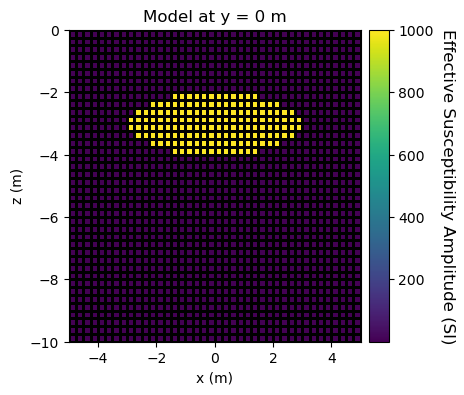

In [552]:
uxo = UXO_object(np.array([0, 0, -3]), 3, 1,0,90)

# create a mesh
axis_length = 10
# New core dimensions
nc = 40  # number of core mesh cells in x, y, and z
dh = axis_length/nc  # core cell width (to fit the [-5, 5] and [-10, 0] range)
h = [(dh, nc)]  # Core region only, no padding
mesh = TensorMesh([h, h, h], x0=[-axis_length/2, -axis_length/2, -axis_length])
# mesh.plot_grid()

# Define susceptibility values
chi_surrounding = 0.1
chi_object = 1000

nC=mesh.nC
model_map = maps.IdentityMap(nP= 3*nC)

field_direction = mat_utils.dip_azimuth2cartesian(inclination, declination)
model = chi_surrounding * np.ones(mesh.nC)
boundary_points = uxo.get_boundary_points()
indices = model_builder.get_indices_polygon(mesh, boundary_points)
model[indices] = chi_object
model_nofield = model
susceptibility_model = np.outer(model, field_direction)
model = mkvc(susceptibility_model)

# Plot Effective Susceptibility Model
fig = plt.figure(figsize=(4, 4))

plotting_map = maps.IdentityMap(nP=mesh.nC)
plotting_model = model_nofield
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * plotting_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(plotting_model), np.max(plotting_model)),
)
ax1.set_title("Model at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(plotting_model), vmax=np.max(plotting_model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label(
    "Effective Susceptibility Amplitude (SI)", rotation=270, labelpad=15, size=12
)

In [547]:
# Define receiver locations on the surface (e.g., in the xy-plane at z = 0)
n_rx = 15  # Number of receivers along each axis
x_rx = np.linspace(-axis_length/2, axis_length/2, n_rx)
y_rx = x_rx
xx, yy = np.meshgrid(x_rx, y_rx)
rx_locations = np.c_[xx.ravel(), yy.ravel(), 0.2*np.ones(n_rx ** 2)]  # Receivers at z = -5

# Set up magnetic receivers to measure TMI
rx = receivers.Point(rx_locations, components= ["bxz", "byz", "bzz"])
receiver_list = [rx]
# Define a magnetic dipole source (which interacts with the Earth's field)
source_field = sources.UniformBackgroundField(
    receiver_list=receiver_list,
    parameters=(H0, inclination, declination)  # Earth's magnetic field parameters
)

# Set up the survey
survey = magnetics.Survey(source_field)

In [548]:
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    chiMap=model_map,
    model_type="vector",
    store_sensitivities="forward_only",
)

In [549]:
# Run the forward simulation to predict TMI data
dpred = simulation.dpred(model)
n_data = len(dpred)

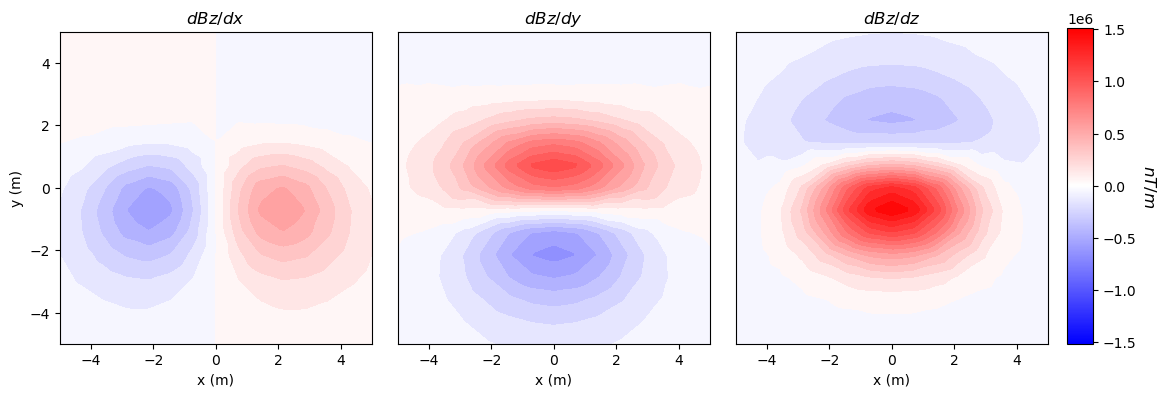

In [550]:
dpred = simulation.dpred(model)
n_data = len(dpred)

# Plot
fig = plt.figure(figsize=(13, 4))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.15, 0.25, 0.78])
plot2Ddata(
    receiver_list[0].locations,
    dpred[0:n_data:3],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("$dBz/dx$")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.36, 0.15, 0.25, 0.78])
cplot2 = plot2Ddata(
    receiver_list[0].locations,
    dpred[1:n_data:3],
    ax=ax2,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot2[0].set_clim((-v_max, v_max))
ax2.set_title("$dBz/dy$")
ax2.set_xlabel("x (m)")
ax2.set_yticks([])

ax3 = fig.add_axes([0.62, 0.15, 0.25, 0.78])
cplot3 = plot2Ddata(
    receiver_list[0].locations,
    dpred[2:n_data:3],
    ax=ax3,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot3[0].set_clim((-v_max, v_max))
ax3.set_title("$dBz/dz$")
ax3.set_xlabel("x (m)")
ax3.set_yticks([])

ax4 = fig.add_axes([0.88, 0.15, 0.02, 0.79])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax4, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT/m$", rotation=270, labelpad=15, size=12)

plt.show()